# 3D reconstruction using 2 image

Key References
- https://www.opencvhelp.org/tutorials/advanced/reconstruction-opencv/

In [7]:
from __future__ import annotations

import os
import random as rd
from typing import TYPE_CHECKING

import cv2 as cv
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pyrender
import scipy.spatial.transform as sci_trans

from project_3d_reconstruction.rendering import render_helper as rh

if TYPE_CHECKING:
    from mpl_toolkits.mplot3d.axes3d import Axes3D

# Generate simple scene

In [17]:
FILE_PATH = os.path.abspath(
    os.path.join(
        os.path.abspath("pyrender_basic_reconstruction.ipynb"), "..", "..", "mesh_files"
    )
)
OBJECTS = [
    os.path.join(FILE_PATH, "building", "untitled.dae"),
    os.path.join(FILE_PATH, "coral_2", "untitled.dae"),
    os.path.join(FILE_PATH, "coral_4", "untitled.dae"),
    os.path.join(FILE_PATH, "rock_1", "untitled.dae"),
    os.path.join(FILE_PATH, "braincoral_1", "untitled.dae"),
]

renderer = rh.RenderHelper()

# Load in mesh files
names = []
for file_path in OBJECTS:
    print(f"Loading {file_path}")
    name = file_path.split("\\")[-2]  # warning slash is different for linux vs windows
    names.append(name)
    renderer.loadFromPath(file_path, name)
print("Done loading")

# Place them in the world
for i in range(1):
    object_name = rd.choice(names)
    renderer.addFromMeshDict('coral_4', rh.positionOnly(0,0,-0.3))

# # Add some cubes
# for i in range(10):
#     renderer.addCube(
#         np.random.uniform(0.1, 0.4),
#         rh.randomTransform(1),
#         color=np.random.randint(0, 180, 3),
#     )

Loading c:\Code\Project3DReconstruction\mesh_files\building\untitled.dae
Loading c:\Code\Project3DReconstruction\mesh_files\coral_2\untitled.dae
Loading c:\Code\Project3DReconstruction\mesh_files\coral_4\untitled.dae
Loading c:\Code\Project3DReconstruction\mesh_files\rock_1\untitled.dae
Loading c:\Code\Project3DReconstruction\mesh_files\braincoral_1\untitled.dae
Done loading


# Save image from two perspectives.

[[1, 0, 0, -0.1], [0, 0.7071067811865476, -0.7071067811865476, -0.5], [0, 0.7071067811865476, 0.7071067811865476, 0.5], [0, 0, 0, 1]]
[[1, 0, 0, 0.1], [0, 0.7071067811865476, -0.7071067811865476, -0.5], [0, 0.7071067811865476, 0.7071067811865476, 0.5], [0, 0, 0, 1]]
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  2.00000000e-01]
 [ 0.00000000e+00  1.00000000e+00 -1.01465364e-17  0.00000000e+00]
 [ 0.00000000e+00 -1.01465364e-17  1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


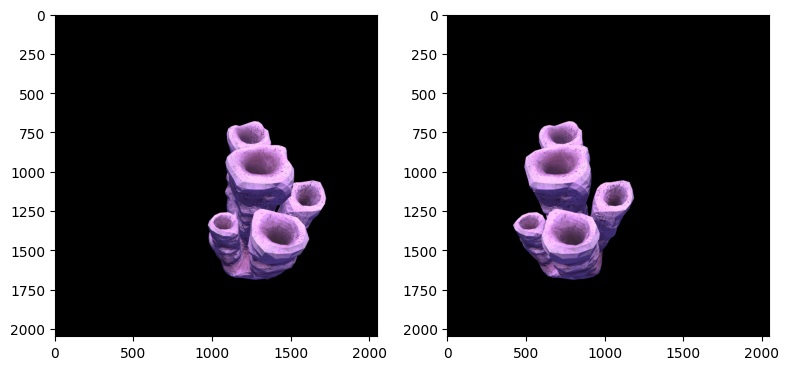

In [18]:
# Render two views
pose1 = rh.pointingAtOrigin2(-0.1, 0.5)
renderer.moveCamera(pose1)
renderer.render(show_image=False, image_filename="test1.png")

pose2 = rh.pointingAtOrigin2(0.1, 0.5)
renderer.moveCamera(pose2)
renderer.render(show_image=False, image_filename="test2.png")

image_1 = cv.imread("test1.png")
image_2 = cv.imread("test2.png")

# actual extrinsics
print(pose1)
print(pose2)
relativePose = np.matmul(np.linalg.inv(pose1), pose2)
print(relativePose)
# camCopy = pyrender.IntrinsicsCamera(fx=512, fy=512, cx=256, cy=256)
# print(camCopy.get_projection_matrix(width=512,height=512))

gray_1 = cv.cvtColor(image_1, cv.COLOR_BGR2GRAY)
gray_2 = cv.cvtColor(image_2, cv.COLOR_BGR2GRAY)

ifig, iaxs = plt.subplots(ncols=2, figsize=(8, 8))
iaxs[0].imshow(image_1)
iaxs[1].imshow(image_2)
ifig.tight_layout()

# Detect SIFT features

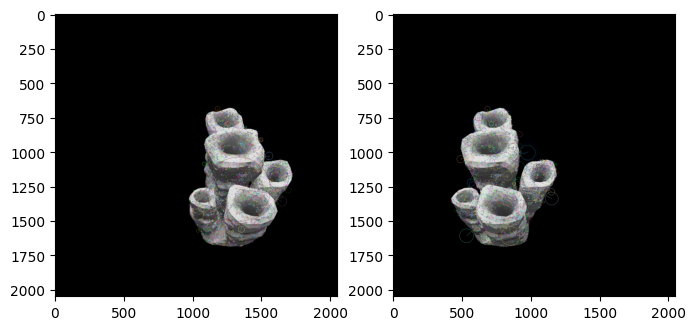

In [19]:
def opponentSIFT(img):
    # Step 1 convert to opponent color space
    # TODO optimize
    B = img[:, :, 0]
    G = img[:, :, 1]
    R = img[:, :, 2]

    O1 = np.divide((R - G), np.sqrt(2))
    O2 = np.divide((R + G - 2 * B), np.sqrt(6))
    O3 = np.divide((R + G + B), np.sqrt(3))
    # visually check opponent color space
    # cv.imwrite('sift_keypointsO1.jpg',np.uint8(O1))
    # cv.imwrite('sift_keypointsO2.jpg',np.uint8(O2))
    # cv.imwrite('sift_keypointsO3.jpg',np.uint8(O3))

    # Step 2 use Harris-Laplace point detector on intensity channel (o3)
    # TODO use a real point detector or figure out what parameters to use with cv SIFT
    # use this space to specify additional parameters
    sift = cv.SIFT_create()
    # sift = cv.SIFT_create(nfeatures=1000, nOctaveLayers=3, sigma=10)

    kp = sift.detect(np.uint8(O3), None)

    # Step 3 compute descriptors for each opponent channel
    _, des1 = sift.compute(np.uint8(O1), kp)
    _, des2 = sift.compute(np.uint8(O2), kp)
    _, des3 = sift.compute(np.uint8(O3), kp)

    # combine into one large descriptor
    des = np.concatenate((des1, des2, des3), axis=1)

    return kp, des


kp1, des1 = opponentSIFT(image_1)
kp2, des2 = opponentSIFT(image_2)

image_kp_1 = cv.drawKeypoints(
    gray_1, kp1, image_1, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)
image_kp_2 = cv.drawKeypoints(
    gray_2, kp2, image_2, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)

ifig, iaxs = plt.subplots(ncols=2, figsize=(8, 8))
iaxs[0].imshow(image_kp_1)
iaxs[1].imshow(image_kp_2)

# Match features (brute-force)

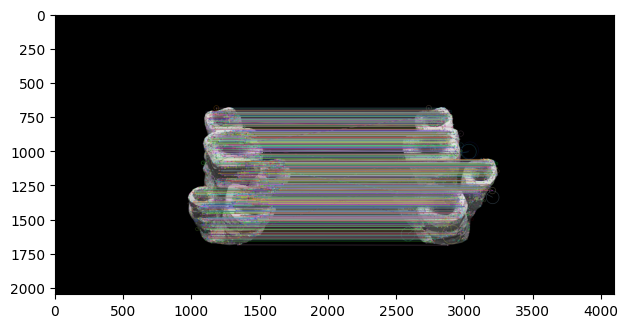

In [20]:
bf = cv.BFMatcher()
bf_matches = bf.knnMatch(des1, des2, k=2)
good = []

for m, n in bf_matches:
    if m.distance < 0.8 * n.distance:
        good.append([m])

image_matches = cv.drawMatchesKnn(
    image_1,
    kp1,
    image_2,
    kp2,
    good,
    None,
    flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
)


ifig, iax = plt.subplots()
iax.imshow(image_matches)
ifig.tight_layout()

# Estimate essential matrix

1776
1745


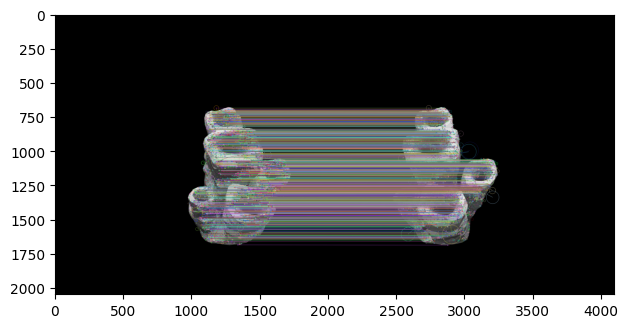

In [21]:
# points_1 = np.array([kp1[match.queryIdx].pt for [match] in good])[:, np.newaxis, :]
# points_2 = np.array([kp2[match.trainIdx].pt for [match] in good])[:, np.newaxis, :]
points_1 = np.int32([kp1[m.queryIdx].pt for [m] in good]).reshape(-1, 1, 2)
points_2 = np.int32([kp2[m.trainIdx].pt for [m] in good]).reshape(-1, 1, 2)

# see pyrender script for intrinsic camera params
intrinsic_mat = np.array([[2048, 0, 1024], [0, 2048, 1024], [0, 0, 1]])

fMatrix, mask = cv.findFundamentalMat(
    points_1,
    points_2,
    method=cv.FM_RANSAC,
    ransacReprojThreshold=3,
    confidence=1 - 1e-6,
)
essential_mat = intrinsic_mat.T @ fMatrix @ intrinsic_mat

# essential_mat, mask = cv.findEssentialMat(
#    points_1, points_2, intrinsic_mat, method=cv.RANSAC, prob=1 - 1e-12, threshold=3
# )
_, est_rot, est_trans, _ = cv.recoverPose(
    essential_mat, points_1, points_2, intrinsic_mat, mask=mask
)

# check the matches kept by ransac - sometimes they're bad
postRansac = []
for i in range(len(mask)):
    if mask[i]:
        postRansac.append(good[i])
print(len(good))
print(len(postRansac))
image_matches = cv.drawMatchesKnn(
    image_1,
    kp1,
    image_2,
    kp2,
    postRansac,
    None,
    flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
)

ifig, iax = plt.subplots()
iax.imshow(image_matches)
ifig.tight_layout()

In [22]:
# check estimated extrinsic params
print(est_rot)
print(est_trans)

[[ 9.99996803e-01  4.54124736e-04  2.48740423e-03]
 [-4.60105408e-04  9.99997004e-01  2.40433837e-03]
 [-2.48630491e-03 -2.40547515e-03  9.99994016e-01]]
[[-9.99628419e-01]
 [-4.90619803e-04]
 [-2.72540429e-02]]


[[ 9.99996803e-01  4.54124736e-04  2.48740423e-03 -9.99628419e-01]
 [-4.60105408e-04  9.99997004e-01  2.40433837e-03 -4.90619803e-04]
 [-2.48630491e-03 -2.40547515e-03  9.99994016e-01 -2.72540429e-02]]
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  2.00000000e-01]
 [ 0.00000000e+00  1.00000000e+00 -1.01465364e-17  0.00000000e+00]
 [ 0.00000000e+00 -1.01465364e-17  1.00000000e+00  0.00000000e+00]]


(-1.0, 1.0)

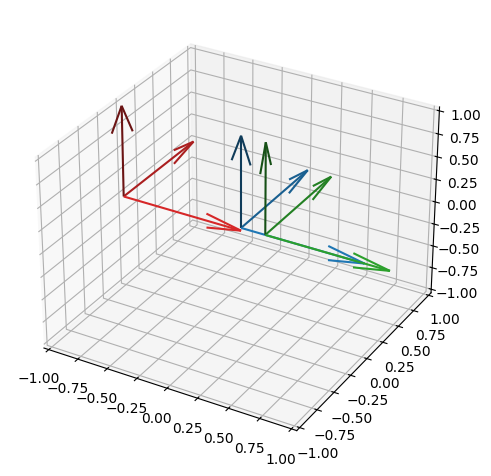

In [24]:
est_extrinsic = np.hstack((est_rot, est_trans))

# act_rot = sci_trans.Rotation.align_vectors(dir_2, dir_1)[0].as_matrix()
# act_extrinsic = np.hstack((act_rot, np.reshape(dir_2 - dir_1, (-1, 1))))
act_extrinsic = relativePose[0:3, :]
print(est_extrinsic)
print(act_extrinsic)

origin = np.hstack((np.eye(3), np.zeros((3, 1))))

all_extrinsics = [origin, act_extrinsic, est_extrinsic]
base_colors = [
    mpl.colors.to_rgb("tab:blue"),
    mpl.colors.to_rgb("tab:green"),
    mpl.colors.to_rgb("tab:red"),
]
cfig, cax = plt.subplots(subplot_kw={"projection": "3d"})
for mat, color in zip(all_extrinsics, base_colors, strict=False):
    pos = mat[:, 3]
    for column, weight in zip(mat[:, :3].T, [1, 0.8, 0.5], strict=False):
        cax.quiver(*pos, *column, color=np.array(color) * weight)

cfig.tight_layout()
cax.set_xlim3d(-1, 1)
cax.set_ylim3d(-1, 1)
cax.set_zlim3d(-1, 1)
# cax.voxels(voxelarray, facecolors=colors, edgecolors=colors);

# note: rotation vectors stay aligned and translation is close enough (within scale factor)

In [35]:
# turn feature points into 3D points using actual extrinsic matrix
points_1_pr = np.int32([kp1[m.queryIdx].pt for [m] in postRansac]).reshape(-1, 1, 2)
points_2_pr = np.int32([kp2[m.trainIdx].pt for [m] in postRansac]).reshape(-1, 1, 2)
R = np.eye(3)
T = np.array([-0.2, 0, 0])#TODO there might be a messed up negative sign somewhere. the relative translation might be a little messed up
f = 2048.0
points3D = np.zeros((len(points_1_pr), 3))
for index in range(len(points_1_pr)):
    point1 = points_1_pr[index]
    point2 = points_2_pr[index]
    ray1 = np.array([point1[0][0], point1[0][1], f])  # *a
    ray2 = R @ np.array([point2[0][0], point2[0][1], f])
    skewSegment = np.cross(ray1, ray2)
    A = np.column_stack([ray1, -ray2, skewSegment])
    coeffs = np.linalg.solve(A, T)
    p13d = coeffs[0] * ray1
    p23d = T + coeffs[1] * ray2
    midpoint = (p13d + p23d) / 2.0

    # convert to world coordinates
    fourVec = np.concatenate([midpoint, [1]])
    points3D[index] = (pose1 @ fourVec)[0:3]
    if index == 0:
        print(ray1)
        print(midpoint)

[1005. 1375. 2048.]
[-0.35765125 -0.48932384 -0.72882562]


[-0.45765125 -0.33064667 -0.36136175]


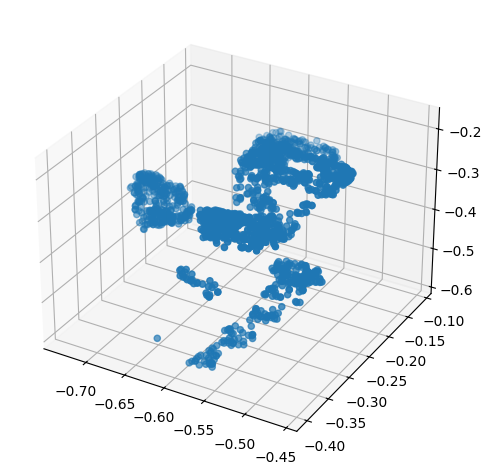

In [36]:
print(points3D[0])
# problem: sift feature points aren't always corners, not all corners make it to the final list either

cfig, cax = plt.subplots(subplot_kw={"projection": "3d"})

cax.scatter(points3D[:, 0], points3D[:, 1], points3D[:, 2])

cfig.tight_layout()


In [3]:
from project_3d_reconstruction.point_cloud_to_mesh import point_cloud_to_mesh_tester as pcloud
import pyvista as pv

c:\Users\alexy\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyvista\jupyter\notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


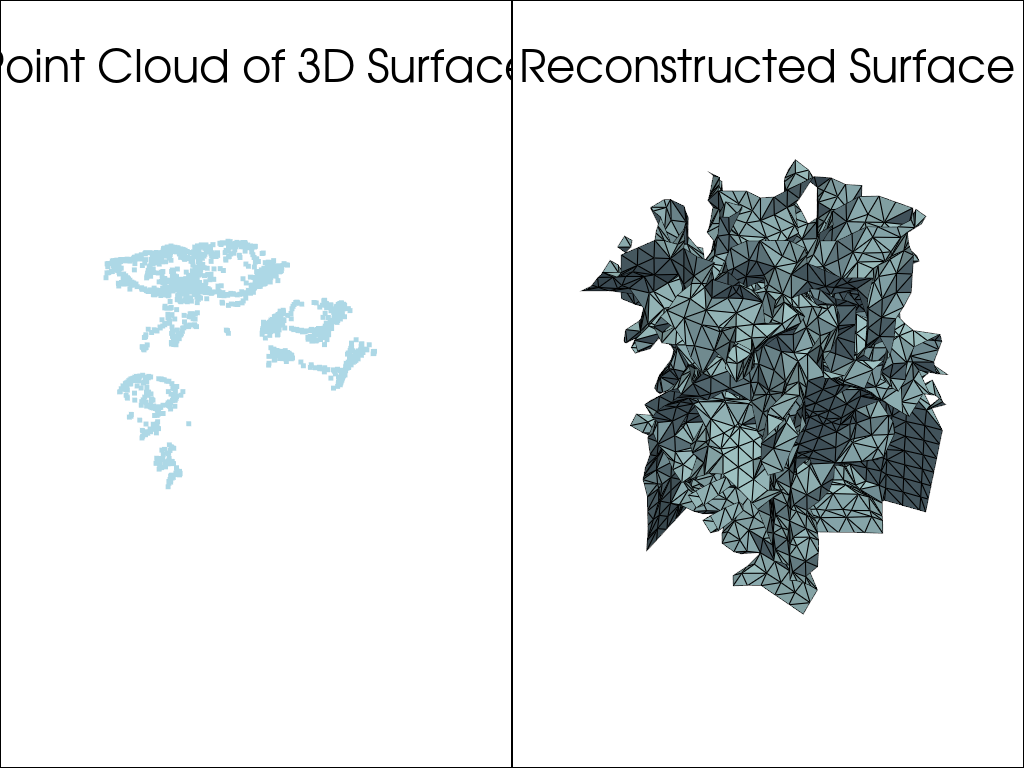

In [32]:
clusters = pcloud.extractClusters(points3D, distance_threshold=0.5)

# Plot it
pl = pv.Plotter(shape=(1, 2))
pl.add_title("Point Cloud of 3D Surface")
pl.add_mesh(points3D)
pl.subplot(0, 1)
pl.add_title("Reconstructed Surface")
for cluster in clusters:
    surf = pcloud.pointsToSurface(cluster)
    pl.add_mesh(surf, color=True, show_edges=True)
pl.show()